# Modeling Airbnb prices
In this post we're going to model the prices of Airbnb appartments in London. In other words, the aim is to build our own price suggestion model. We will be using data from http://insideairbnb.com/ which we collected in April 2018. This work is inspired from the [Airbnb price prediction model](https://d1no007.github.io/OptiBnB/) built by Dino Rodriguez, Chase Davis, and Ayomide Opeyemi.

## Data Preprocessing
The first thing to do is to set the seed in order to be able to reproduce the results.

In [1]:
import random
random.seed(42)

Then we import the listings gathered in the csv file.

In [2]:
import pandas as pd

listings_file_path = 'listings.csv.gz' 
listings = pd.read_csv(listings_file_path, compression="gzip", low_memory=False)
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

The data has 95 columns or features. Our first step is to perform feature selection to reduce this number.

### Feature selection
For some of the features it is already obvious that they won't be of any use just by looking at their name, so we remove these.

In [3]:
useless = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'city', 'state', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'weekly_price', 'monthly_price']
listings.drop(useless, axis=1, inplace=True)

We can also delete the following features as they are only available for old Airbnb appartments. Let's imagine that we are new on Airbnb and we want to rent an appartment. At that time, we won't have any review score for a appartment so we should remove any features related to this.

In [4]:
listings.drop(listings.filter(regex = 'review').columns, axis = 1, inplace = True)
listings.columns

Index(['host_total_listings_count', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'requires_license', 'license', 'jurisdiction_names', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count'],
      dtype='object')

#### Selection on Missing Data 
Features that have a high number of missing values aren't useful for our model so we should remove them.

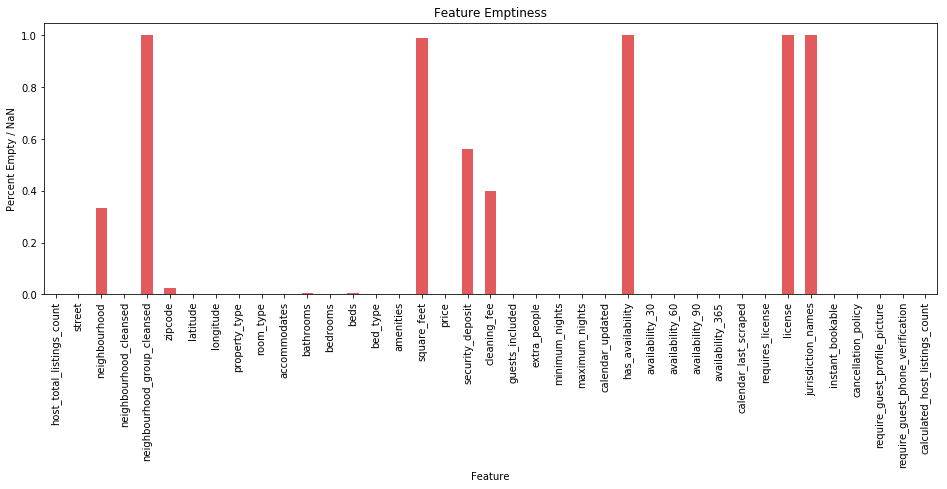

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

percentage_missing_data = listings.isnull().sum() / listings.shape[0]
ax = percentage_missing_data.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent Empty / NaN')
ax.set_title('Feature Emptiness')
plt.show()

As we can see, the features `neighbourhood_group_cleansed`, `square_feet`, `has_availability`, `license` and `jurisdiction_names` mostly have missing values. The features `neighbourhood`, `cleaning_fee` and `security_deposit` are more than 30% empty which is too much in our opinion. The `zipcode` feature also has some missing values but we can either remove these values or impute them within reasonable accuracy. 

In [6]:
useless = ['neighbourhood', 'neighbourhood_group_cleansed', 'square_feet', 'security_deposit', 'cleaning_fee', 
           'has_availability', 'license', 'jurisdiction_names']
listings.drop(useless, axis=1, inplace=True)

#### Selection on Sparse Categorical Features
Let's have a look at the categorical data to see the number of unique values.

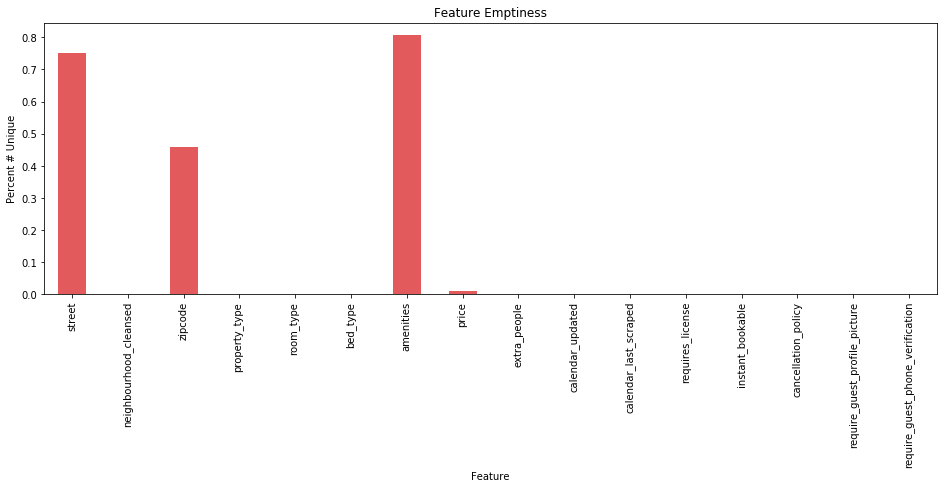

In [7]:
categories = listings.columns[listings.dtypes == 'object']
percentage_unique = listings[categories].nunique() / listings.shape[0]

ax = percentage_unique.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent # Unique')
ax.set_title('Feature Emptiness')
plt.show()

We can see that the `street` and `amenities` features have a large number of unique values. It would require some natural language processing to properly wrangle these into useful features. We believe we have enough location information with `neighbourhood_cleansed` and `zipcode` so we'll remove `street`. We also remove `amenities`, `calendar_updated` and `calendar_last_updated` features as these are too complicated to process for the moment. 

In [8]:
to_drop = ['street', 'amenities', 'calendar_last_scraped', 'calendar_updated']
listings.drop(to_drop, axis=1, inplace=True)

Now, let's have a look at the `zipcode` feature. The above visualisation shows us that there are lots of different postcodes, maybe too many?

In [9]:
print("Number of Zipcodes:", listings['zipcode'].nunique())

Number of Zipcodes: 24774


Indeed, there are too many zipcodes. If we leave this feature as is it might cause overfitting. Instead we can regroup the postcodes. At the moment, they are separated as in the following example: KT1 1PE. We'll keep the first part of the zipcode (e.g. KT1) and accept that this gives us some less precise location information.

In [10]:
listings['zipcode'] = listings['zipcode'].str.slice(0,3)
listings['zipcode'] = listings['zipcode'].fillna("OTHER")
print("Number of Zipcodes:", listings['zipcode'].nunique())

Number of Zipcodes: 461


Now, I only have 461 different zipcodes, which is much better than before. Let's have a look at the data dataframe to be sure that the postcodes have the correct form.

In [11]:
listings.head()

,host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,availability_30,availability_60,availability_90,availability_365,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,1.0,Kingston upon Thames,KT1,51.410036,-0.306323,Apartment,Private room,1,1.0,1.0,...,1,31,61,61,f,f,flexible,f,f,1
1,1.0,Kingston upon Thames,KT2,51.411482,-0.290704,Apartment,Private room,2,1.0,1.0,...,29,59,89,364,f,f,moderate,f,f,1
2,1.0,Kingston upon Thames,KT2,51.415851,-0.286496,Apartment,Private room,2,1.0,1.0,...,0,0,0,0,f,f,flexible,f,f,1
3,1.0,Kingston upon Thames,KT2,51.415723,-0.292246,House,Private room,2,1.5,1.0,...,0,0,0,0,f,f,flexible,f,f,1
4,1.0,Kingston upon Thames,KT3,51.404285,-0.275426,House,Private room,1,1.0,1.0,...,29,59,89,179,f,f,flexible,f,f,1


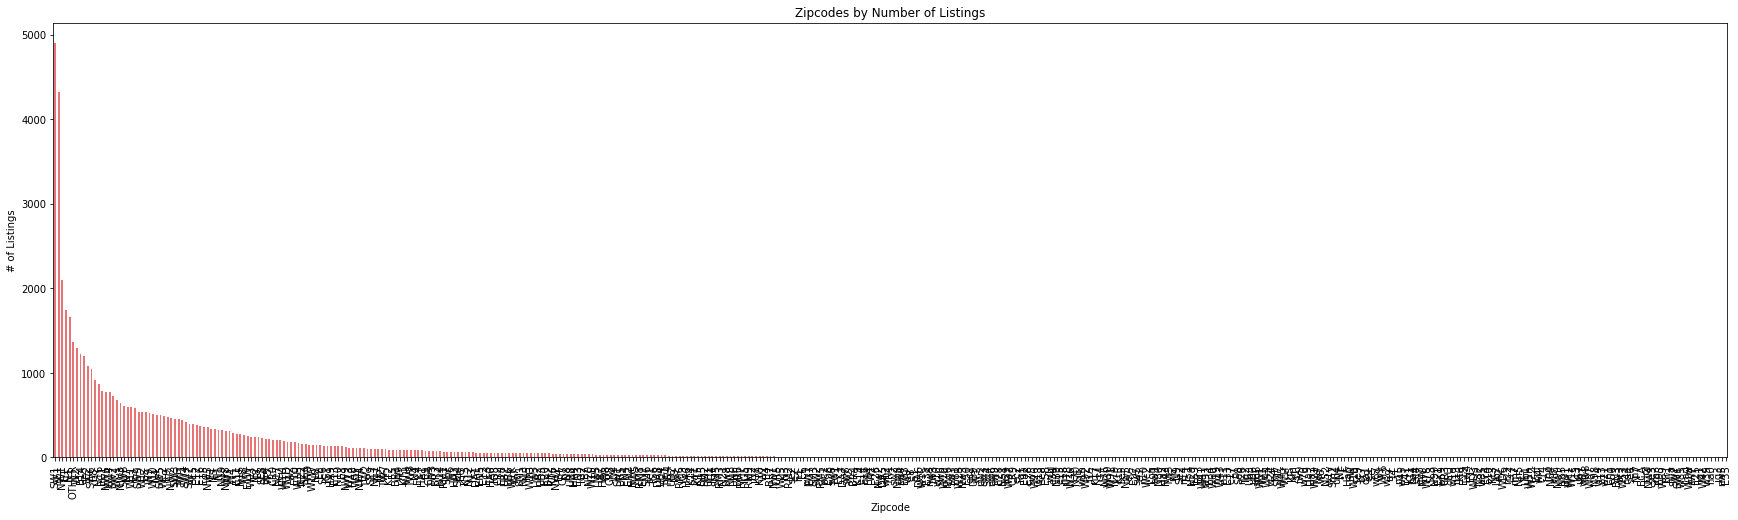

In [12]:
count_per_zipcode = listings['zipcode'].value_counts()
ax = count_per_zipcode.plot(kind='bar', figsize = (30,8), color = '#E35A5C', alpha = 0.85)
ax.set_title("Zipcodes by Number of Listings")
ax.set_xlabel("Zipcode")
ax.set_ylabel("# of Listings")
plt.show()

As we can see, a lot of zipcodes contain less than 100 appartments and a few zipcodes contain most of the appartments. Let's keep these ones.

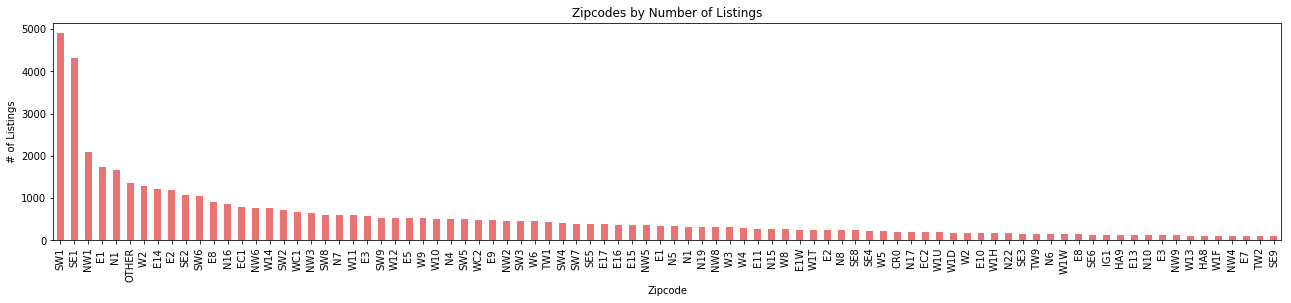

Number of entries removed:  5484


In [13]:
relevant_zipcodes = count_per_zipcode[count_per_zipcode > 100].index
listings_zip_filtered = listings[listings['zipcode'].isin(relevant_zipcodes)]

# Plot new zipcodes distribution
count_per_zipcode = listings_zip_filtered['zipcode'].value_counts()
ax = count_per_zipcode.plot(kind='bar', figsize = (22,4), color = '#E35A5C', alpha = 0.85)
ax.set_title("Zipcodes by Number of Listings")
ax.set_xlabel("Zipcode")
ax.set_ylabel("# of Listings")

plt.show()

print('Number of entries removed: ', listings.shape[0] - listings_zip_filtered.shape[0])

This distribution is much better, and we only removed 5484 rows from our dataframe which contained about 53904 rows.

Now let's have a look at the distribution for the `neighbourhood_cleansed feature`.

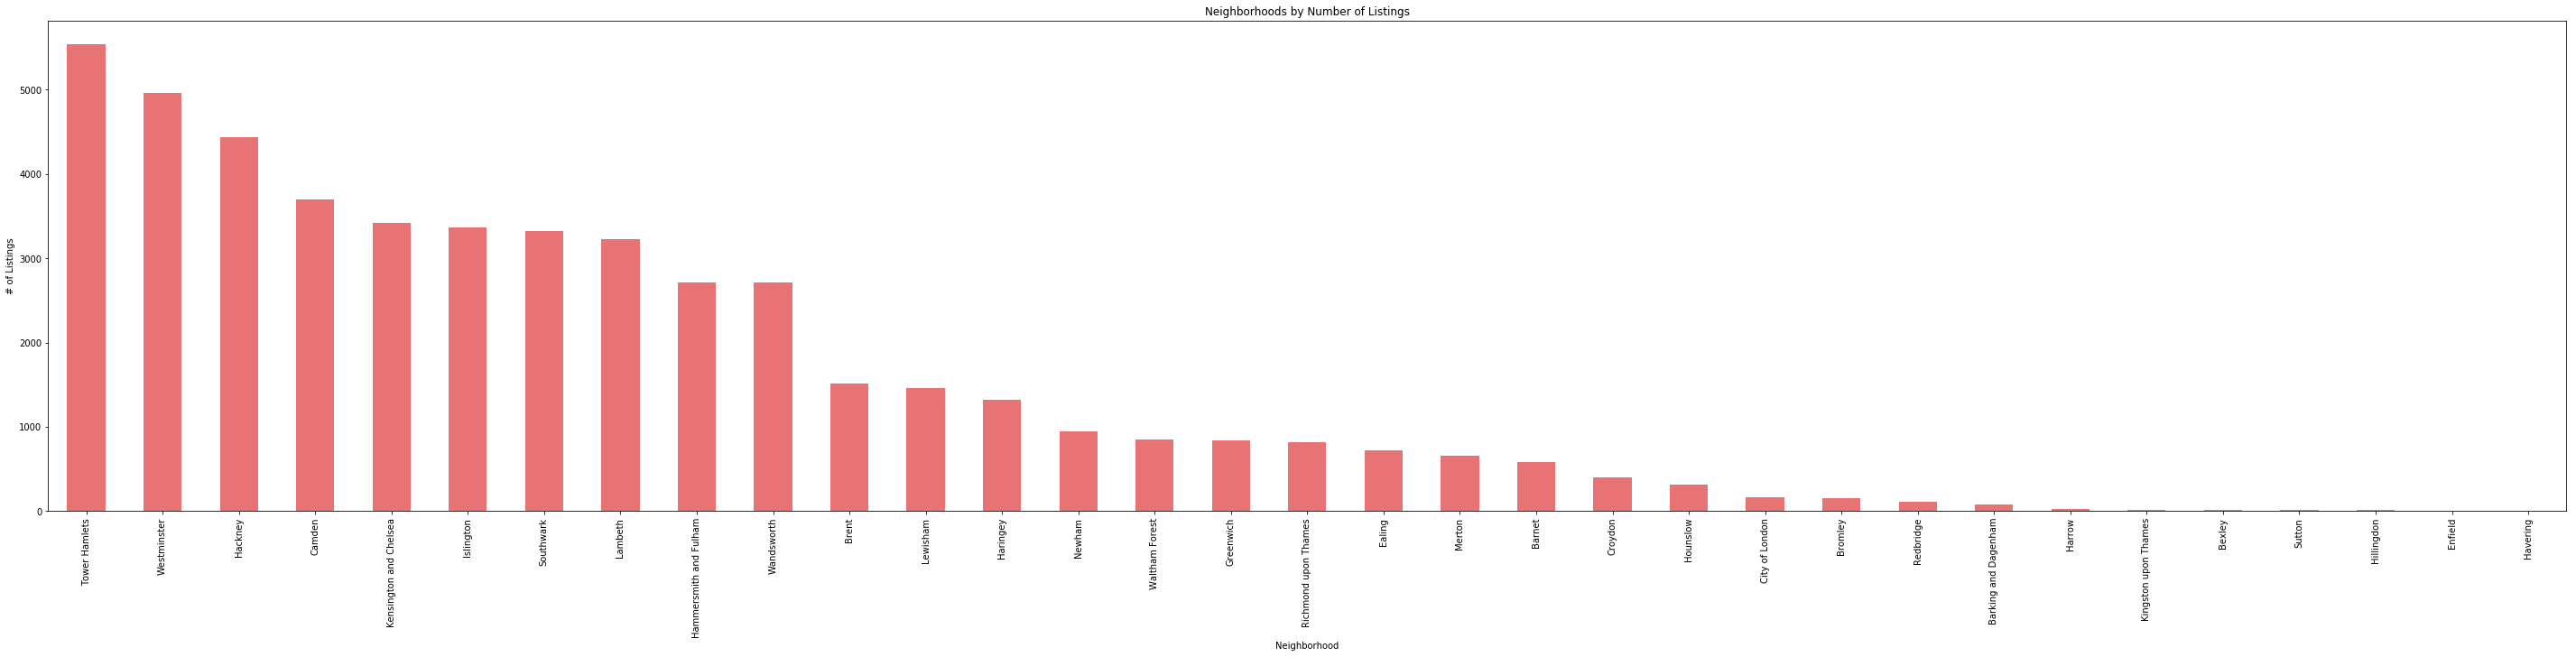

Number of Neighborhoods: 33


In [14]:
# Focus on neighbourhood_cleansed

# Get number of listings in neighborhoods
count_per_neighborhood = listings_zip_filtered['neighbourhood_cleansed'].value_counts()

# Plot number of listings in each neighborhood
ax = count_per_neighborhood.plot(kind='bar', figsize = (50,10), color = '#E35A5C', alpha = 0.85)
ax.set_title("Neighborhoods by Number of Listings")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("# of Listings")
plt.show()

print("Number of Neighborhoods:", len(count_per_neighborhood))

The distribution is fine and there are only 33 neighborhoods. But some only contain around 10 appartments and this is useless for our model so let's keep the neighborhoods that contain more than 100 appartments.

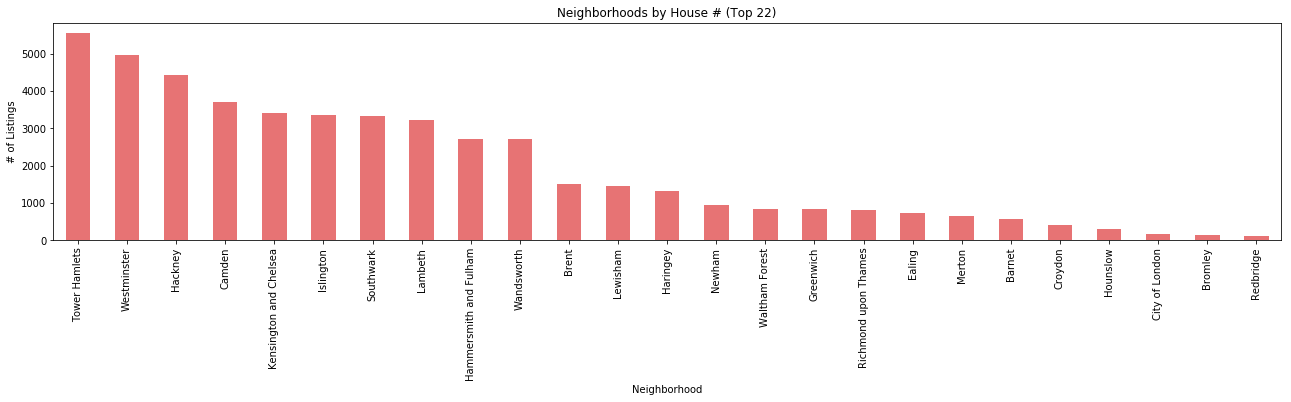

Number of entries removed:  173


In [15]:
relevant_neighborhoods = count_per_neighborhood[count_per_neighborhood > 100].index
listings_neighborhood_filtered = listings_zip_filtered[listings_zip_filtered['neighbourhood_cleansed'].isin(relevant_neighborhoods)]

# Plot new neighborhoods distribution
count_per_neighborhood = listings_neighborhood_filtered['neighbourhood_cleansed'].value_counts()
ax = count_per_neighborhood.plot(kind='bar', figsize = (22,4), color = '#E35A5C', alpha = 0.85)
ax.set_title("Neighborhoods by House # (Top 22)")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("# of Listings")

plt.show()

print('Number of entries removed: ', listings_zip_filtered.shape[0] - listings_neighborhood_filtered.shape[0])

By doing this, we only removed 173 rows. We still have more than 46000 rows in our data.

The next step is to examine multicollinearity.

#### Selection on Correlated Features

In [16]:
import numpy as np
from sklearn import preprocessing

# Function to label encode categorical variables.
# Input: array (array of values)
# Output: array (array of encoded values)
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Temporary dataframe
temp_data = listings_neighborhood_filtered.copy()

# Delete additional entries with NaN values
temp_data = temp_data.dropna(axis=0)

# Encode categorical data
temp_data = temp_data.apply(encode_categorical)
# Compute matrix of correlation coefficients
corr_matrix = temp_data.corr()

corr_matrix

,host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,availability_30,availability_60,availability_90,availability_365,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
host_total_listings_count,1.000000,-0.012579,0.047793,-0.012979,-0.071976,0.062116,-0.131357,0.198319,0.165851,0.209925,...,-0.060110,-0.069431,-0.076003,-0.070112,NaN,0.146111,0.164194,-0.017255,0.006566,0.669057
neighbourhood_cleansed,-0.012579,1.000000,0.003328,-0.302733,0.179035,-0.056675,-0.006117,0.023104,0.008597,-0.000389,...,-0.003836,-0.010341,-0.011009,-0.009244,NaN,0.020990,0.040604,0.001989,0.000092,0.029394
zipcode,0.047793,0.003328,1.000000,-0.373074,-0.627589,-0.022068,-0.130317,0.076929,0.042599,0.057120,...,-0.005104,-0.008958,-0.010710,0.009421,NaN,-0.000491,0.049190,-0.014428,0.010924,0.012256
latitude,-0.012979,-0.302733,-0.373074,1.000000,0.140862,-0.051516,0.007928,-0.017890,-0.028255,-0.045592,...,-0.039670,-0.039075,-0.037523,-0.030103,NaN,0.010806,0.012319,0.008761,0.001707,0.014551
longitude,-0.071976,0.179035,-0.627589,0.140862,1.000000,0.003956,0.104162,-0.060852,-0.051775,-0.064843,...,-0.008221,-0.006811,-0.003874,-0.009832,NaN,-0.013801,-0.021398,0.015613,0.003309,-0.038896
property_type,0.062116,-0.056675,-0.022068,-0.051516,0.003956,1.000000,0.202812,0.056563,0.234284,0.188911,...,0.041762,0.048879,0.044834,0.031474,NaN,0.004598,-0.078796,0.009363,-0.017384,-0.037722
room_type,-0.131357,-0.006117,-0.130317,0.007928,0.104162,0.202812,1.000000,-0.552787,-0.135641,-0.375012,...,0.189672,0.210795,0.211935,0.146392,NaN,0.029777,-0.230055,0.009881,-0.039027,-0.144706
accommodates,0.198319,0.023104,0.076929,-0.017890,-0.060852,0.056563,-0.552787,1.000000,0.463455,0.758304,...,-0.068308,-0.099249,-0.097895,-0.031711,NaN,0.039419,0.241419,0.000839,0.060075,0.201753
bathrooms,0.165851,0.008597,0.042599,-0.028255,-0.051775,0.234284,-0.135641,0.463455,1.000000,0.543456,...,-0.013049,-0.019711,-0.025004,-0.014161,NaN,-0.001588,0.085349,-0.014896,0.007856,0.128801
bedrooms,0.209925,-0.000389,0.057120,-0.045592,-0.064843,0.188911,-0.375012,0.758304,0.543456,1.000000,...,-0.072836,-0.092369,-0.098422,-0.071705,NaN,-0.037056,0.128916,-0.010849,0.021893,0.121240


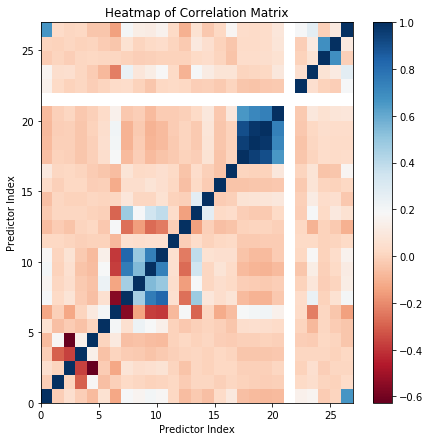

In [17]:
# Display heat map 
plt.figure(figsize=(7, 7))
plt.pcolor(corr_matrix, cmap='RdBu')
plt.xlabel('Predictor Index')
plt.ylabel('Predictor Index')
plt.title('Heatmap of Correlation Matrix')
plt.colorbar()

plt.show()

This reveals that `calculated_host_listings_count` is highly correlated with `host_total_listings_count`  so we'll keep the latter. We also see that the `availability_*` variables are correlated with each other. We'll keep `availability_365` as this one is less correlated with other variables. Finally, we decide to drop `requires_license` which has an odd correlation result of NA's which will not be useful in our model.

In [18]:
useless = ['calculated_host_listings_count', 'availability_30', 'availability_60', 'availability_90', 'requires_license']
listings_processed = listings_neighborhood_filtered.drop(useless, axis=1)

### Manipulation on Price values
Now, we need to manipulate some features that relate to `price` as they have a price formatting: they contain the thousand separator (',') and the '$' symbol. Let's get rid of it and transform these features into numeric values.

In [19]:
listings_processed = listings_processed.copy()
listings_processed['price'] = listings_processed['price'].str.replace('\$|,', '')
listings_processed['price'] = pd.to_numeric(listings_processed['price'])

listings_processed['extra_people'] = listings_processed['extra_people'].str.replace('\$|,', '')
listings_processed['extra_people'] = pd.to_numeric(listings_processed['extra_people'])

### One Hot Encoding for Categorical Features 
Categorical variables need to be One Hot Encoded in order to be converted into several numerical features and used in a Machine Learning model. This method is very well explained in this Kaggle notebook: https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding.

In [20]:
# One Hot Encoding for categorical variables
listings_processed = pd.get_dummies(listings_processed)
listings_processed.shape

(48247, 171)

### Data Splitting: Features / labels - Training set / testing set
Now we split into into features and labels and training and testing sets. We also convert the train and test dataframe into numpy arrays so that they can be used to train and test the models.

In [21]:
# Shuffle the data to ensure a good distribution for the training and testing sets
from sklearn.utils import shuffle
listings_processed = shuffle(listings_processed)

# Extract features and labels
y = listings_processed['price']
X = listings_processed.drop('price', axis = 1)

# Training and Testing Sets
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

train_X = np.array(train_X)
test_X = np.array(test_X)
train_y = np.array(train_y)
test_y = np.array(test_y)

train_X.shape, test_X.shape

((36185, 170), (12062, 170))

## Modelling 

Now that the data preprocessing is over, I can start the second part of this work: applying different Machine Learning models. We decided to apply 3 different models:

* Random Forest, with the RandomForestRegressor from the Scikit-learn library
* Gradient Boosting method, with the XGBRegressor from the XGBoost library
* Neural Network, with the MLPRegressor from the Scikit-learn library.

Each time, we applied the model with its default hyperparameters and we then tuned the model in order to get the best hyperparameters. The metrics we use to evaluate the models is the median absolute error due to the presence of extreme outliers and skewness in the data set.

### Application of the Random Forest Regressor 

Let's start with the Random Forest model.

#### With default hyperparameters
##### Creation of the pipeline

We first create a pipeline that imputes the missing values then scales the data and finally applies the model. We then fit this pipeline to the training set.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# Create the pipeline (imputer + scaler + regressor)
my_pipeline_RF = make_pipeline(Imputer(), StandardScaler(),
                               RandomForestRegressor(random_state=42))

# Fit the model
my_pipeline_RF.fit(train_X, train_y)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='au...estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

##### Evaluation of the model

We evaluate this model on the test set, using the median absolute error to measure the performance of the model. We'll also include the root-mean-square error (RMSE) for completeness. Since we'll be doing this repeatedly it is good practice to create a function.

In [23]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_model(model, predict_set, evaluate_set):
    predictions = model.predict(predict_set)
    print("Median Absolute Error: " + str(round(median_absolute_error(predictions, evaluate_set), 2))) 
    RMSE = round(sqrt(mean_squared_error(predictions, evaluate_set)), 2)
    print("RMSE: " + str(RMSE)) 

In [24]:
evaluate_model(my_pipeline_RF, test_X, test_y)

Median Absolute Error: 14.2
RMSE: 126.16


We evaluate the model on the training set too, to be sure that we have avoided overfitting.

In [25]:
evaluate_model(my_pipeline_RF, train_X, train_y)

Median Absolute Error: 5.1
RMSE: 31.43


These first results are quite good. To be sure we have made a good feature selection we can have a look at the feature importances.

In [35]:
importances = my_pipeline_RF.steps[2][1].feature_importances_
feature_importances = pd.DataFrame({"feature":X.columns.values, "importance":importances})
feature_importances.sort_values("importance", ascending=False).head(22)

,feature,importance
5,bedrooms,0.222978
4,bathrooms,0.152850
2,longitude,0.092258
143,property_type_Other,0.048795
11,availability_365,0.048298
0,host_total_listings_count,0.045807
1,latitude,0.044980
9,minimum_nights,0.042580
151,room_type_Entire home/apt,0.034680
115,zipcode_W2,0.032714


In [36]:
# Cumulative importances
feature_importances.importance.sum()

1.0

#### Hyperparameters tuning

We had some good results with the default hyperparameters of the Random Forest regressor. But we can improve the results with some hyperparameter tuning. There are two main methods available for this:

* Random search
* Grid search.

You have to provide a parameter grid to these methods. Then, they both try different combinations of parameters within the grid you provided. But the first one only tries several combinations whereas the second one tries all the possible combinations with the grid you provided.

What we have done is that we started with a random search to roughly evaluate a good combination of parameters. Once this is done, we use the grid search to get more precise results.

In [37]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently used:\n')
pprint(my_pipeline_RF.get_params())

Parameters currently used:

{'imputer': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'imputer__axis': 0,
 'imputer__copy': True,
 'imputer__missing_values': 'NaN',
 'imputer__strategy': 'mean',
 'imputer__verbose': 0,
 'memory': None,
 'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_impurity_split

##### Randomized Search with Cross Validation 

In [38]:
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap}

In [39]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 2 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = my_pipeline_RF, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 2, verbose=2,
                               random_state = 42, n_jobs = -1, 
                               scoring = 'neg_median_absolute_error')
# Fit our model
rf_random.fit(train_X, train_y)

rf_random.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 429.1min finished


{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_depth': 35,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 5,
 'randomforestregressor__n_estimators': 1000}

##### Grid Search with Cross Validation 

In [40]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [30, 35, 40], 
    'randomforestregressor__max_features': ['auto'],
    'randomforestregressor__min_samples_leaf': [2],
    'randomforestregressor__min_samples_split': [4, 5, 6],
    'randomforestregressor__n_estimators': [950, 1000, 1050] 
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = my_pipeline_RF, 
                           param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2, 
                           scoring = 'neg_median_absolute_error')

# Fit the grid search to the data
grid_search.fit(train_X, train_y)

grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 114.4min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 262.8min finished


{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_depth': 30,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 4,
 'randomforestregressor__n_estimators': 1050}

##### Final Model

In [41]:
# Create the pipeline (imputer + scaler + regressor)
my_pipeline_RF_grid = make_pipeline(Imputer(), StandardScaler(),
                                      RandomForestRegressor(random_state=42,
                                                            bootstrap = True,
                                                            max_depth = 30,
                                                            max_features = 'auto',
                                                            min_samples_leaf = 2,
                                                            min_samples_split = 4,
                                                            n_estimators = 1050))

# Fit the model
my_pipeline_RF_grid.fit(train_X, train_y)

evaluate_model(my_pipeline_RF_grid, test_X, test_y)

Median Absolute Error: 13.57
RMSE: 125.04


We get better results with the tuned model than with default hyperparameters, but the improvement of the median absolute error is not amazing. Maybe we will have a better precision if we use another model.

### Application of the Gradient Boosting Regressor

Let's try with the XGBoost gradient boosting model. This model often produces really good results in Kaggle competitions. The first step is to use it with the default hyperparameters.
#### With default hyperparameters 

In [42]:
from xgboost import XGBRegressor

# Create the pipeline: Imputation + Scale + MLP regressor
my_pipeline_XGB = make_pipeline(Imputer(), StandardScaler(), 
                                XGBRegressor(random_state = 42))

# Fit the model
my_pipeline_XGB.fit(train_X, train_y)

evaluate_model(my_pipeline_XGB, test_X, test_y)

Median Absolute Error: 15.94
RMSE: 120.88


For the moment, the tuned and even not tuned Random Forest models give better results. I want to see if hyperparameter tuning will make this model better than the Random Forest one.

#### Hyperparameters tuning

In [43]:
# Look at parameters used by our current model
print('Parameters currently used:\n')
pprint(my_pipeline_XGB.get_params())

Parameters currently used:

{'imputer': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'imputer__axis': 0,
 'imputer__copy': True,
 'imputer__missing_values': 'NaN',
 'imputer__strategy': 'mean',
 'imputer__verbose': 0,
 'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('imputer',
            Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)),
           ('standardscaler',
            StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('xgbregressor',
            XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_a

#### Grid Search with Cross Validation 

In [44]:
param_grid = {'xgbregressor__learning_rate': [0.1, 0.05], 
              'xgbregressor__max_depth': [5, 7, 9],
              'xgbregressor__n_estimators': [100, 500, 900]}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = my_pipeline_XGB,
                           param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2, 
                           scoring = 'neg_median_absolute_error')

# Fit the grid search to the data
grid_search.fit(train_X, train_y)

grid_search.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 48.5min finished


{'xgbregressor__learning_rate': 0.05,
 'xgbregressor__max_depth': 9,
 'xgbregressor__n_estimators': 500}

#### Final Model

In [45]:
# Create the pipeline: Imputation + Scale + MLP regressor
my_pipeline_XGB_grid = make_pipeline(Imputer(), StandardScaler(), 
                                     XGBRegressor(random_state = 42,
                                                  learning_rate = 0.05,
                                                  max_depth = 9,
                                                  n_estimators = 500))

# Fit the model
my_pipeline_XGB_grid.fit(train_X, train_y)

evaluate_model(my_pipeline_XGB_grid, test_X, test_y)

Median Absolute Error: 13.54
RMSE: 120.78


The tuned XGBoost model gives better results than the not tuned one. It also gives almost the same results as the tuned Random Forest model (MAE: 13.57).

### Application of the Multi Layer Perceptron Regressor

Now let's try a Neural Network, or to be more precise, a multilayer perceptron which is a class of Neural Network. I apply this regressor with default hyperparameters except from the maximum numer of iteration in order to let it run until the end.

#### With default hyperparameters 

In [46]:
from sklearn.neural_network import MLPRegressor

# Create the pipeline: Imputation + Scale + Feature Selection + MLP regressor
my_pipeline_NN = make_pipeline(Imputer(), StandardScaler(), 
                               MLPRegressor(random_state = 42,
                                            max_iter = 400))

# Fit the model
my_pipeline_NN.fit(train_X, train_y)

evaluate_model(my_pipeline_NN, test_X, test_y)

Median Absolute Error: 18.76
RMSE: 124.0


The results are not very good compared to the two previous models. Let's try to tune this neural network, maybe the default parameters are very not good for this data.

#### Grid Search with Cross Validation 

In [47]:
# Which parameters in my pipeline?
my_pipeline_NN.get_params()

{'imputer': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'imputer__axis': 0,
 'imputer__copy': True,
 'imputer__missing_values': 'NaN',
 'imputer__strategy': 'mean',
 'imputer__verbose': 0,
 'memory': None,
 'mlpregressor': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=400, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
        solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
        warm_start=False),
 'mlpregressor__activation': 'relu',
 'mlpregressor__alpha': 0.0001,
 'mlpregressor__batch_size': 'auto',
 'mlpregressor__beta_1': 0.9,
 'mlpregressor__beta_2': 0.999,
 'mlpregressor__early_stopping': False,
 'mlpregressor__epsilon': 1e-08,
 'mlpregressor__hidden_layer_sizes': (100,),
 'mlpregressor__le

In [48]:
param_grid = {
    'mlpregressor__activation': ['logistic', 'tanh'],
    'mlpregressor__solver': ['sgd', 'adam'],
    'mlpregressor__early_stopping': [True, False],
    'mlpregressor__hidden_layer_sizes': [(100,), (100, 50), (100, 100), (100, 100, 100)],
    'mlpregressor__learning_rate_init': [0.001, 0.0001],
}

grid_search = GridSearchCV(estimator = my_pipeline_NN,
                           param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2,
                           scoring = 'neg_median_absolute_error')

grid_search.fit(train_X, train_y)

grid_search.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 696.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 797.8min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 831.4min finished
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'mlpregressor__activation': 'logistic',
 'mlpregressor__early_stopping': False,
 'mlpregressor__hidden_layer_sizes': (100, 50),
 'mlpregressor__learning_rate_init': 0.0001,
 'mlpregressor__solver': 'adam'}

#### Final Model

In [51]:
# Create the pipeline: imputation + MLP regressor
my_pipeline_NN_grid = make_pipeline(Imputer(), StandardScaler(),
                                    MLPRegressor(hidden_layer_sizes = (100, 50),
                                                 activation = 'logistic',
                                                 early_stopping = False,
                                                 learning_rate_init = 0.0001,
                                                 solver = 'adam',
                                                 max_iter = 500,
                                                 random_state = 42)) 

# Fit the model
my_pipeline_NN_grid.fit(train_X, train_y)

evaluate_model(my_pipeline_NN_grid, test_X, test_y)

Median Absolute Error: 15.23
RMSE: 129.49


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The tuned Neural Network is much better than the one with default hyperparameters. However, it is still much less precise than the first two models.

### Visualision of the models' performance

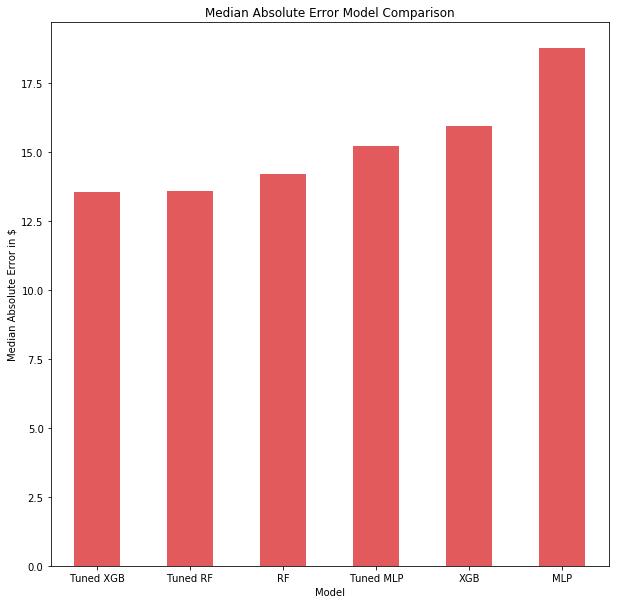

In [65]:
error_val = pd.DataFrame({'error_val':[14.2, 13.57, 15.94, 13.54, 18.76, 15.23]},
                        index = ['RF','Tuned RF','XGB', 'Tuned XGB', 'MLP', 'Tuned MLP'])
error_val = error_val.sort_values('error_val')
plt.figure(figsize=(10,10))
ax = error_val.error_val.plot(kind='bar', align = 'center', color='#E35A5C')
plt.xticks(rotation=0)
plt.xlabel('Model')
plt.ylabel('Median Absolute Error in $')
plt.title('Median Absolute Error Model Comparison')
plt.show()

The tuned Random Forest and XGBoost gave the best results on the test set. Surprisingly, the Multi Layer Perceptron with default parameters gave the highest Median Absolute errors, and the tuned one did not even give better results than the default Random Forest. This is unusual, maybe the Multi Layer Perceptron needs more data to perform better, or it might need more tuning on important hyperparameters such as the hidden_layer_sizes. 

## Conclusion

In this post we modelled Airbnb apartment prices using descriptive data from the airbnb website. First, we preprocessed the data to remove any redundant features and reduce the sparsity of the data. Then we applied three different algorithms, initially with default parameters which we then tuned. In our results the tuned Random Forest and tuned XGBoost performed best. 

To further improve our models we could include more feature engineering, for example time-based features. We could also try more extensive hyperparameter tuning. If you would like to give it a go yourself, the code and data for this post can be found on [GitHub](https://github.com/MangoTheCat/Modelling-Airbnb-Prices#XGB)